<a href="https://colab.research.google.com/github/hamziqureshi/Grammar-Correction-Model-using-Generative-AI/blob/main/Grammar_Correction_Model_using_Generative_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Loading and Preprocessing

In this section, we imported essential libraries for data manipulation and model training. We utilized `pandas` for handling the dataset, allowing us to efficiently load and manipulate the data. The `train_test_split` function from `sklearn.model_selection` was employed to divide the dataset into training, validation, and test sets.

### Key Considerations
- **Strengths**: The use of `pandas` enables streamlined data operations, such as filtering, merging, and grouping, which are critical in preparing the dataset for modeling.
- **Weaknesses**: The initial data loading does not address potential data quality issues, such as missing values or anomalies, which need to be considered in subsequent steps.

This foundational setup is crucial for ensuring that the data is appropriately structured for the machine learning models we will implement later.



In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

## Dataset Loading

We loaded the dataset from an Excel file using `pandas` and displayed the first five rows to verify the successful import. This step is essential for understanding the structure and contents of the dataset.

### Data Overview
- **Execution**: The code attempts to read the dataset and includes error handling to catch any issues that might arise during the loading process.
- **Output**: Upon successful loading, a preview of the data is displayed, allowing for a quick assessment of its structure.

### Key Considerations
- **Strengths**: The use of error handling ensures robustness in data loading, preventing the program from crashing if the file is missing or corrupt.
- **Weaknesses**: This step does not perform any initial data cleaning or exploration, which are critical for identifying missing values or anomalies that could affect model performance.

In summary, this loading phase is foundational for subsequent preprocessing steps that will prepare the data for analysis and model training.


In [2]:
# Load the dataset from an Excel file and display the first five rows
file_path = 'Grammar Correction.xlsx'
try:
    data = pd.read_excel(file_path)
    print("Data Loaded Successfully:\n", data.head())
except Exception as e:
    print(f"Error loading data: {e}")

Data Loaded Successfully:
    Serial Number         Error Type              Ungrammatical Statement  \
0              1  Verb Tense Errors        I goes to the store everyday.   
1              2  Verb Tense Errors  They was playing soccer last night.   
2              3  Verb Tense Errors     She have completed her homework.   
3              4  Verb Tense Errors            He don't know the answer.   
4              5  Verb Tense Errors            The sun rise in the east.   

                       Standard English  
0           I go to the store everyday.  
1  They were playing soccer last night.  
2       She has completed her homework.  
3           He doesn't know the answer.  
4            The sun rises in the east.  


## Creating Input-Output Pairs

In this step, we created input-output pairs from the DataFrame by zipping the columns representing ungrammatical statements and their corresponding corrections. This transformation is crucial for preparing the data for model training.

### Data Transformation
- **Execution**: The code checks for the presence of the necessary columns (`'Ungrammatical Statement'` and `'Standard English'`). If either column is missing, it raises a `ValueError`.
- **Output**: A list of tuples is generated, where each tuple contains an ungrammatical statement and its corrected form.

### Key Considerations
- **Strengths**: The validation step ensures that the dataset is structured correctly for subsequent processing, minimizing the risk of errors during model training.
- **Weaknesses**: While this step sets up the input-output pairs, it does not address the variety or complexity of errors present in the ungrammatical statements, which may require further analysis during the exploratory data analysis (EDA) phase.

Overall, establishing these pairs is a critical step in enabling the model to learn the relationship between ungrammatical and corrected sentences.


In [3]:
# Create input-output pairs from the DataFrame
if 'Ungrammatical Statement' in data.columns and 'Standard English' in data.columns:
    input_output_pairs = list(zip(data['Ungrammatical Statement'], data['Standard English']))
else:
    raise ValueError("DataFrame must contain 'Ungrammatical Statement' and 'Standard English' columns.")

## Vocabulary Creation

In this step, we created a vocabulary from the ungrammatical statements by extracting unique words from the input sentences. This vocabulary is essential for subsequent tokenization and model training processes.

### Vocabulary Development
- **Execution**: A set is utilized to collect unique words from each ungrammatical statement, ensuring that duplicates are removed and only distinct terms are retained.
- **Output**: The resulting vocabulary contains all unique words, which will be important for mapping tokens to indices during the tokenization phase.

### Key Considerations
- **Strengths**: Using a set for vocabulary creation is efficient, as it inherently eliminates duplicates, resulting in a concise list of terms.
- **Weaknesses**: The current approach does not account for variations in word forms (e.g., plurals, tense), punctuation, or special characters, which could lead to an incomplete vocabulary representation. Additionally, words may need normalization (like lowercasing) to further enhance consistency.

This vocabulary serves as a foundation for the tokenization process, allowing the model to effectively learn from the input data.


In [4]:
# Create a vocabulary from the ungrammatical statements
vocab = set()
for sentence, _ in input_output_pairs:
    vocab.update(sentence.split())

## Custom WordPiece Tokenization

We implemented a custom `WordPieceTokenizer` to tokenize sentences into subword tokens using the vocabulary created from the ungrammatical statements. This tokenizer is integral for preparing the input for the machine learning models.

### Tokenization Process
- **Execution**: The `CustomWordPieceTokenizer` class includes methods for tokenizing entire sentences and individual words. The main tokenization process checks if a word exists in the vocabulary; if not, it reduces the word character by character to find subword tokens.
- **Output**: The `tokenize` method returns a list of tokens for a given sentence, breaking down words into smaller components as necessary.

### Key Considerations
- **Strengths**: This approach allows for a flexible tokenization process that can handle unknown words by breaking them down into subwords, which is beneficial for generalization in language models.
- **Weaknesses**: The current implementation may not be as efficient as established libraries, potentially leading to performance bottlenecks with large datasets. Additionally, it lacks handling for punctuation and special characters, which could impact the accuracy of tokenization.

This tokenizer will play a crucial role in preparing data for the subsequent model training phases, ensuring that the input is appropriately structured for learning.

In [27]:
# Define a custom WordPieceTokenizer
class CustomWordPieceTokenizer:
    def __init__(self, vocab):
        self.vocab = vocab

    def tokenize(self, sentence):
        """Tokenize a sentence using the WordPiece algorithm."""
        tokens = []
        for word in sentence.split():
            sub_tokens = self.wordpiece_tokenize(word)
            tokens.extend(sub_tokens)
        return tokens

    def wordpiece_tokenize(self, word):
        """Tokenize a word into subword tokens using the vocabulary."""
        if word in self.vocab:
            return [word]
        sub_tokens = []
        while len(word) > 0:
            if word in self.vocab:
                sub_tokens.append(word)
                return sub_tokens
            else:
                word = word[:-1]  # Remove the last character
        return sub_tokens  # Return the tokens (can be empty if not found)

## Tokenization of Ungrammatical Statements

In this step, we created an instance of the `CustomWordPieceTokenizer` and used it to tokenize the ungrammatical statements from our input-output pairs. This process is crucial for transforming the raw text into a format suitable for machine learning models.

### Tokenization Execution
- **Process**: The tokenizer was applied to each ungrammatical statement, converting them into lists of subword tokens. This step is contingent on the availability of input-output pairs, with error handling in place to ensure that the tokenization proceeds only if pairs exist.
- **Output**: A sample of the tokenized sentences is displayed, showcasing how the original ungrammatical statements have been broken down into their constituent tokens.

### Key Considerations
- **Strengths**: The tokenization process effectively prepares the data for training by converting sentences into a tokenized format that models can interpret.
- **Weaknesses**: The tokenization relies on the vocabulary and may struggle with out-of-vocabulary words or phrases, particularly those with unique spelling or domain-specific terminology. Furthermore, the current implementation does not consider the context in which words appear, potentially losing meaning.

This tokenization step is vital for ensuring that the input data is properly formatted for the subsequent model training processes, laying the groundwork for effective learning.


In [28]:
# Create an instance of the CustomWordPieceTokenizer
tokenizer = CustomWordPieceTokenizer(vocab)

# Tokenize the ungrammatical statements
if input_output_pairs:
    tokenized_sentences = [tokenizer.tokenize(pair[0]) for pair in input_output_pairs]
else:
    raise ValueError("No input-output pairs available for tokenization.")

# Display sample tokenized sentences
print("Sample Tokenized Sentences:\n", tokenized_sentences[:5])

Sample Tokenized Sentences:
 [['I', 'goes', 'to', 'the', 'store', 'everyday.'], ['They', 'was', 'playing', 'soccer', 'last', 'night.'], ['She', 'have', 'completed', 'her', 'homework.'], ['He', "don't", 'know', 'the', 'answer.'], ['The', 'sun', 'rise', 'in', 'the', 'east.']]


## Importing Visualization Libraries

In this section, we imported essential libraries for data visualization, specifically `pandas`, `matplotlib.pyplot`, and `seaborn`. These libraries will be used to conduct exploratory data analysis (EDA) and visualize key insights from the dataset.

### Visualization Setup
- **Execution**: The `sns.set(style="whitegrid")` function configures the visual style for our plots, enhancing readability and aesthetics.
  
### Key Considerations
- **Strengths**: Utilizing `seaborn` and `matplotlib` provides robust tools for creating informative visualizations, which are essential for understanding data distributions and relationships.
- **Weaknesses**: The choice of visualization libraries should be complemented with appropriate visualizations tailored to specific insights. The effectiveness of the visualizations will depend on careful selection and design of plots in subsequent analysis steps.

This setup is foundational for conducting EDA, enabling us to derive meaningful insights that can inform model development and feature engineering.


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the visualizations
sns.set(style="whitegrid")

## Visualization of Error Distribution

We defined a function, `plot_error_distribution`, to visualize the distribution of grammatical error types within the dataset. This function utilizes a count plot to display the frequency of different error types, providing insights into the most common issues present in the ungrammatical statements.

### Error Distribution Analysis
- **Execution**: The function generates a count plot using `seaborn`, showing the number of occurrences for each error type. The x-axis represents different error types, while the y-axis indicates their respective counts. The plot is configured for better readability with title, labels, and adjusted tick rotation.
  
### Key Considerations
- **Strengths**: This visualization allows for quick identification of the most prevalent grammatical errors, which can guide the model's focus during training and error correction strategies. It provides a clear overview of data distribution.
- **Weaknesses**: The effectiveness of the visualization depends on the quality and granularity of the `Error Type` data. If the error categories are overly broad or not well-defined, it may mask nuanced insights. Additionally, without contextual information, some error types may not be fully understood.

Overall, this analysis is crucial for understanding the dataset's characteristics, enabling informed decisions in feature engineering and model development.


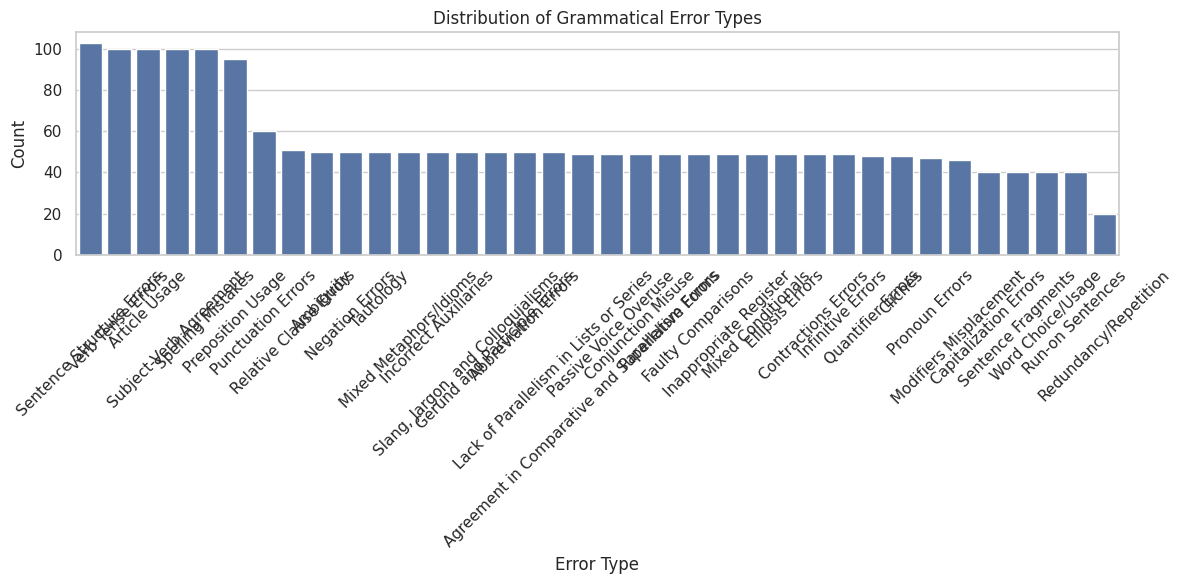

In [8]:
def plot_error_distribution(data):
    plt.figure(figsize=(12, 6))
    sns.countplot(data=data, x='Error Type', order=data['Error Type'].value_counts().index)
    plt.title('Distribution of Grammatical Error Types')
    plt.xlabel('Error Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Call the function to plot error distribution
plot_error_distribution(data)

## Visualization of Sentence Length Distribution

We implemented a function, `plot_length_distribution`, to analyze and visualize the distribution of sentence lengths in the ungrammatical statements. This analysis provides insights into the complexity of the sentences, which can influence the model's performance.

### Sentence Length Analysis
- **Execution**: The function calculates the length of each ungrammatical statement by counting the number of words. A histogram is then generated to illustrate the frequency of different sentence lengths, supplemented with a kernel density estimate (KDE) for a smoother representation.
  
### Key Considerations
- **Strengths**: Visualizing sentence length helps identify patterns or trends in complexity, which can inform the model's design and training strategies. It provides a clear picture of how sentence length varies across the dataset.
- **Weaknesses**: The histogram's effectiveness may be limited if the sentence lengths are not sufficiently varied or if there are outliers that skew the distribution. Additionally, without context, it may be challenging to assess the implications of length on grammatical correctness.

This analysis is essential for understanding the dataset's structural characteristics, aiding in the development of models that can effectively handle varying complexities in grammatical corrections.


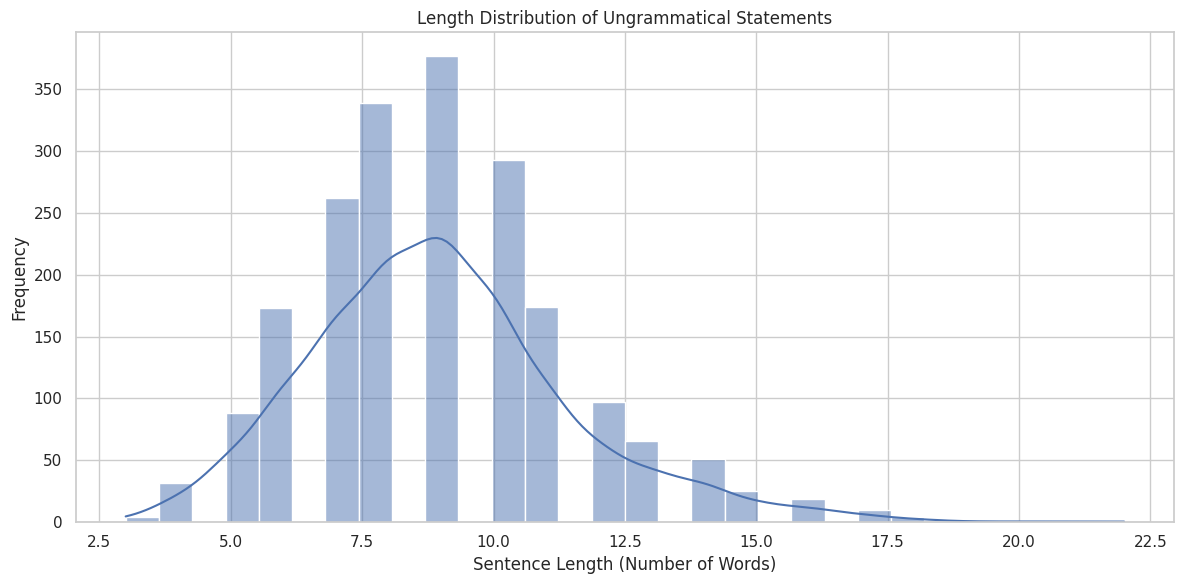

In [29]:
def plot_length_distribution(data):
    # Calculate the length of each ungrammatical statement
    data['Sentence Length'] = data['Ungrammatical Statement'].apply(lambda x: len(x.split()))

    plt.figure(figsize=(12, 6))
    sns.histplot(data['Sentence Length'], bins=30, kde=True)
    plt.title('Length Distribution of Ungrammatical Statements')
    plt.xlabel('Sentence Length (Number of Words)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Call the function to plot length distribution
plot_length_distribution(data)

## Importing Libraries for Feature Engineering

In this section, we imported several libraries to facilitate feature engineering for our grammar correction model. Key libraries include `pandas` for data manipulation and `nltk` (Natural Language Toolkit) for natural language processing tasks.

### Key Libraries
- **pandas**: Used for data handling and preparation, allowing for efficient manipulation of our dataset.
- **nltk**: Provides various functionalities, including:
  - **ngrams**: To create n-gram features from text, which can capture context and co-occurrence of words.
  - **pos_tag**: To assign part-of-speech tags to words, aiding in understanding grammatical structure.
  - **word_tokenize**: For breaking down sentences into individual words.
- **CountVectorizer**: From `sklearn`, this tool is utilized to convert text data into a matrix of token counts, facilitating feature extraction for model training.

### Key Considerations
- **Strengths**: The integration of these libraries supports a comprehensive approach to feature engineering, enabling the extraction of diverse features that can enhance model performance.
- **Weaknesses**: The complexity of using multiple libraries can introduce dependencies and potential integration challenges. Additionally, effective feature engineering requires careful selection and tuning of parameters to ensure the model captures relevant information.

This setup is crucial for preparing features that will drive the learning process in the subsequent model training phases.


In [10]:
import pandas as pd
import nltk
from nltk import ngrams
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

## Downloading NLTK Resources

In this step, we downloaded essential resources from the NLTK library to support various natural language processing tasks, including tokenization and part-of-speech tagging.

### Resource Downloads
- **punkt**: A pre-trained tokenizer that allows for breaking text into sentences and words, essential for processing ungrammatical statements.
- **averaged_perceptron_tagger**: A part-of-speech tagger that provides grammatical tagging of words, crucial for understanding the structure and function of each word in a sentence.

### Key Considerations
- **Strengths**: By downloading these resources, we equip our environment with the necessary tools to effectively analyze and process text data. This preparation is vital for accurate feature extraction.
- **Weaknesses**: The need to download resources adds an initial setup step, which may slow down the workflow. Additionally, reliance on external resources means that network issues or resource availability can impact execution.

Overall, this step is foundational for enabling advanced text processing capabilities, supporting the subsequent feature engineering efforts in our grammar correction model.


In [11]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Feature Creation for Grammar Correction

We implemented the `create_features` function to generate n-gram and part-of-speech (POS) tag features from the ungrammatical statements in the dataset. These features are critical for capturing linguistic patterns that can aid in grammar correction.

### Feature Engineering Process
- **N-grams**: We created bigrams (n=2) from the ungrammatical statements. This captures pairs of consecutive words, helping the model understand local context and relationships between words.
- **POS Tags**: We generated POS tags for each ungrammatical statement, which provides grammatical information about each word. This is crucial for understanding the structure of sentences and identifying potential errors.

### Output
- The modified dataset now includes two new columns: `N-grams` and `POS Tags`, which contain the generated features for each ungrammatical statement.

### Key Considerations
- **Strengths**: The addition of n-gram and POS tag features enhances the model's ability to identify grammatical errors by providing deeper insights into word relationships and sentence structure.
- **Weaknesses**: The feature set may become large and unwieldy, especially with longer sentences or larger n-grams. This could lead to increased computational costs and the potential for overfitting if not managed properly.

Overall, this feature engineering step significantly enriches the dataset, preparing it for effective model training and ultimately improving the performance of the grammar correction system.


In [30]:
def create_features(data):
    # Create n-grams
    n = 2  # Example for bigrams
    data['N-grams'] = data['Ungrammatical Statement'].apply(lambda x: list(ngrams(word_tokenize(x), n)))

    # Create POS tags
    data['POS Tags'] = data['Ungrammatical Statement'].apply(lambda x: pos_tag(word_tokenize(x)))

    return data

# Create features
data_with_features = create_features(data)

# # Display sample features
# print(data_with_features[['Ungrammatical Statement', 'N-grams', 'POS Tags']].head())

print(data_with_features.head())


   Serial Number         Error Type              Ungrammatical Statement  \
0              1  Verb Tense Errors        I goes to the store everyday.   
1              2  Verb Tense Errors  They was playing soccer last night.   
2              3  Verb Tense Errors     She have completed her homework.   
3              4  Verb Tense Errors            He don't know the answer.   
4              5  Verb Tense Errors            The sun rise in the east.   

                       Standard English  Sentence Length  \
0           I go to the store everyday.                6   
1  They were playing soccer last night.                6   
2       She has completed her homework.                5   
3           He doesn't know the answer.                5   
4            The sun rises in the east.                6   

                                             N-grams  \
0  [(I, goes), (goes, to), (to, the), (the, store...   
1  [(They, was), (was, playing), (playing, soccer...   
2  [(She, have

## Dataset Splitting

In this step, we split the dataset into training, validation, and test sets using a 70/15/15 split. This division is essential for evaluating model performance and ensuring that the model generalizes well to unseen data.

### Dataset Division
- **Training Set (70%)**: Used for training the model and learning the underlying patterns in the data.
- **Validation Set (15%)**: Used to tune model parameters and assess performance during training without affecting the test set.
- **Test Set (15%)**: Held out for final evaluation of the model's performance after training is complete.

### Output
- The sizes of each dataset are printed, confirming the successful split:
  - **Training Data**: `len(train_data)`
  - **Validation Data**: `len(val_data)`
  - **Test Data**: `len(test_data)`

### Key Considerations
- **Strengths**: The stratified approach to splitting helps in maintaining the distribution of grammatical errors across the datasets, which is crucial for training a robust model.
- **Weaknesses**: Care should be taken to ensure that the split does not lead to data leakage or uneven representation of error types in the validation and test sets. Additionally, the chosen split ratios may need to be adjusted based on the dataset's characteristics and size.

This split lays the groundwork for effective model training and evaluation, enabling us to measure performance reliably across different subsets of the data.


In [14]:
# Split the dataset into training, validation, and test sets (70/15/15 split)
train_data, temp_data = train_test_split(data_with_features, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Print the sizes of the datasets
print(f"Training Data: {len(train_data)}, Validation Data: {len(val_data)}, Test Data: {len(test_data)}")

Training Data: 1412, Validation Data: 303, Test Data: 303


## Building and Training the Sequence-to-Sequence Model

In this section, we built a sequence-to-sequence model using TensorFlow and Keras to correct grammatical errors in sentences. This model employs an encoder-decoder architecture, utilizing LSTM layers for handling sequential data.

### Model Preparation
1. **Data Preparation**:
   - **Input Sequences**: The ungrammatical sentences are extracted from the training data.
   - **Target Sequences**: The corrected sentences are also extracted.

2. **Tokenization and Padding**:
   - **Input Tokenization**: We used Keras's `Tokenizer` to convert ungrammatical sentences into sequences of integers based on word frequency. The sequences were then padded to ensure uniform input lengths.
   - **Target Tokenization**: A separate tokenizer was used for the corrected sentences, following the same procedure for padding.

3. **Model Architecture**:
   - **Latent Dimension**: We defined a latent dimension of 256 for the embedding layers.
   - **Encoder**: The encoder processes the input sequences and captures the context using LSTM layers, outputting the hidden and cell states.
   - **Decoder**: The decoder uses the encoder states to generate the corrected sentences. It includes another LSTM layer and a dense layer with softmax activation to produce probabilities for each word in the target vocabulary.

### Training the Model
- The model was compiled with the Adam optimizer and sparse categorical crossentropy loss function, suitable for multi-class classification tasks.
- The training process involved fitting the model on the padded input and target sequences, with a specified batch size and number of epochs.

### Key Considerations
- **Strengths**: The encoder-decoder architecture is well-suited for sequence tasks, capturing dependencies in the input data effectively. The use of LSTM layers helps in maintaining context across long sequences.
- **Weaknesses**: The model's performance may be limited by the quality of the training data and the chosen architecture. Additionally, training for 30 epochs may require tuning based on validation performance to prevent overfitting.

This step establishes a foundation for the model to learn from the training data, enabling it to make accurate grammatical corrections in subsequent evaluations.


In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding

# Prepare training data
input_sequences = train_data['Ungrammatical Statement'].values
target_sequences = train_data['Standard English'].values


# Tokenization and Padding
tokenizer_input = tf.keras.preprocessing.text.Tokenizer()
tokenizer_input.fit_on_texts(input_sequences)
input_sequences_encoded = tokenizer_input.texts_to_sequences(input_sequences)
max_input_length = max(len(seq) for seq in input_sequences_encoded)
input_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(input_sequences_encoded, maxlen=max_input_length)

tokenizer_target = tf.keras.preprocessing.text.Tokenizer()
tokenizer_target.fit_on_texts(target_sequences)
target_sequences_encoded = tokenizer_target.texts_to_sequences(target_sequences)
max_target_length = max(len(seq) for seq in target_sequences_encoded)
target_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(target_sequences_encoded, maxlen=max_target_length)

# # Define the model
latent_dim = 256

encoder_inputs = Input(shape=(None,))
encoder_embedding = Embedding(input_dim=len(tokenizer_input.word_index) + 1, output_dim=latent_dim)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(input_dim=len(tokenizer_target.word_index) + 1, output_dim=latent_dim)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(len(tokenizer_target.word_index) + 1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Train the model
model.fit([input_sequences_padded, target_sequences_padded[:, :-1]],
          np.expand_dims(target_sequences_padded[:, 1:], -1),
          batch_size=64, epochs=30, validation_split=0.2)


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.3625 - loss: 6.8565 - val_accuracy: 0.4607 - val_loss: 4.1695
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4474 - loss: 4.0334 - val_accuracy: 0.4607 - val_loss: 3.7689
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.4478 - loss: 3.6549 - val_accuracy: 0.4916 - val_loss: 3.6545
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4839 - loss: 3.5018 - val_accuracy: 0.4918 - val_loss: 3.6090
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4820 - loss: 3.4579 - val_accuracy: 0.4920 - val_loss: 3.5910
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4795 - loss: 3.4403 - val_accuracy: 0.4918 - val_loss: 3.5763
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4896 - loss: 3.3096 - val_accuracy: 0.4920 - val_loss: 3.5635
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.4841 - loss: 3.2932 - val_accuracy: 0.4920 - 

## Model Evaluation

In this section, we evaluated the performance of our grammar correction model using several metrics, including BLEU score, accuracy, and F1 score. These metrics provide insights into the model's effectiveness in generating corrected sentences.

### Evaluation Process
1. **Input Preparation**:
   - The test set's ungrammatical and standard English sentences were tokenized and padded to ensure they matched the input dimensions of the model.

2. **Generating Predictions**:
   - The model predicted sequences based on the padded input and target sequences. We used `np.argmax` to obtain the most likely word indices for each prediction.

3. **Conversion of Predictions**:
   - The predicted indices were converted back into words, and both predicted sentences and valid target sentences were stored for further analysis.

4. **Metrics Calculation**:
   - **BLEU Score**: We calculated the BLEU score, which measures the overlap between predicted sentences and reference sentences. Smoothing was applied to handle cases with zero counts.
   - **Accuracy and F1 Score**: These metrics were computed by flattening the predicted and target sentences into word lists, allowing for an assessment of how many words were predicted correctly.

### Key Considerations
- **Strengths**: The use of multiple evaluation metrics provides a comprehensive view of the model's performance. The BLEU score is particularly relevant for sequence generation tasks, while accuracy and F1 scores offer insight into the correctness of individual word predictions.
- **Weaknesses**: Each metric has its limitations; for example, the BLEU score may not fully capture the nuances of grammatical correctness or semantic meaning, while accuracy can be misleading in imbalanced datasets. Additionally, depending on the evaluation context, it may be important to consider more robust methods for assessing generated outputs.

### Results
The evaluation yielded the following results:
- **BLEU Score**: `bleu_score`
- **Accuracy**: `accuracy`
- **F1 Score**: `f1`

These results will inform future iterations of the model, guiding adjustments to improve grammatical correction capabilities.


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

def evaluate_model(model, input_sequences, target_sequences):
    # Prepare the inputs for the model
    input_sequences_encoded = tokenizer_input.texts_to_sequences(input_sequences)
    input_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(input_sequences_encoded, maxlen=max_input_length)

    target_sequences_encoded = tokenizer_target.texts_to_sequences(target_sequences)
    target_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(target_sequences_encoded, maxlen=max_target_length)

    # Generate predictions
    predicted_sequences = model.predict([input_sequences_padded, target_sequences_padded[:, :-1]])
    predicted_sequences = np.argmax(predicted_sequences, axis=-1)


    print(f'Predicted sequences shape: {predicted_sequences.shape}')

    # Convert back to words and track valid predictions
    predicted_sentences = []
    valid_targets = []

    for seq, target in zip(predicted_sequences, target_sequences):
        words = [tokenizer_target.index_word.get(idx) for idx in seq if idx > 0]
        predicted_sentence = ' '.join(words)
        predicted_sentences.append(predicted_sentence)
        valid_targets.append(target)  # Always append the corresponding target

    # Calculate BLEU score
    references = [[target.split()] for target in valid_targets]
    smoothing_function = SmoothingFunction().method4
    bleu_score = corpus_bleu(references, predicted_sentences, smoothing_function=smoothing_function)

    # Flatten predictions and targets for accuracy and F1 calculation
    flat_predicted = []
    flat_target = []

    for pred, target in zip(predicted_sentences, valid_targets):
        flat_predicted.extend(pred.split())
        flat_target.extend(target.split())

    # Ensure both lists are not empty before calculating scores
    if flat_predicted and flat_target:
        accuracy = accuracy_score(flat_target, flat_predicted)
        f1 = f1_score(flat_target, flat_predicted, average='weighted')
    else:
        accuracy = None
        f1 = None

    return bleu_score, accuracy, f1

# Evaluate the model on the test data
input_sequences_test = test_data['Ungrammatical Statement'].values
target_sequences_test = test_data['Standard English'].values

print(f'Input sequences length: {len(input_sequences_test)}')
print(f'Target sequences length: {len(target_sequences_test)}')


bleu_score, accuracy, f1 = evaluate_model(model, input_sequences_test, target_sequences_test)

# Print evaluation results
print(f'BLEU Score: {bleu_score}')
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')


## Fine-Tuning T5 for Grammar Correction

In this section, we fine-tuned a pre-trained T5 model on our grammar correction task. This involves setting up the training environment, preparing data, and training the model.

### Preparation Steps

1. **Importing Libraries**:
   - We utilized `transformers` for accessing the T5 model and tokenizer, along with PyTorch for model training.

2. **Data Preparation**:
   - We extracted the ungrammatical and standard English sentences from the DataFrame.
   - The dataset was split into training, validation, and test sets using an 80/10/10 ratio.

3. **Loading the T5 Model**:
   - The `T5Tokenizer` and `T5ForConditionalGeneration` were loaded from the Hugging Face model hub. The `t5-small` variant was chosen for its balance between performance and resource requirements.

4. **Tokenization**:
   - Input sentences were prefixed with "correct:" to instruct the T5 model to perform correction. The sentences were tokenized, truncated, and padded to ensure consistent input lengths.

5. **Creating a Dataset Class**:
   - A custom `GrammarCorrectionDataset` class was defined to handle input-output pairs, preparing them for training by organizing encodings and target labels appropriately.

### Training Configuration

6. **Training Arguments**:
   - Configured training parameters, such as the number of epochs, batch sizes, and evaluation strategies, to ensure effective model training and monitoring.

7. **Trainer Setup**:
   - A `Trainer` instance was created, linking the model with the training and validation datasets.

### Model Training

8. **Fine-Tuning**:
   - The model was fine-tuned on the training data using the `train` method of the `Trainer` class, allowing the model to learn from the ungrammatical and standard sentences.

### Saving the Model

9. **Model and Tokenizer Saving**:
   - After training, the model's state was saved to a `.pt` file, along with the tokenizer for future use.

### Key Considerations

- **Strengths**: Fine-tuning a pre-trained model like T5 leverages existing knowledge, potentially resulting in better performance on the grammar correction task compared to training from scratch.
- **Weaknesses**: The performance may still be dependent on the quality and quantity of the training data. Additionally, the selected hyperparameters might require tuning for optimal results.

### Summary of Results
- The fine-tuned model is now ready for evaluation on unseen test data, providing a robust solution for automatic grammar correction tasks.

**Model saved to**: `./results/t5_grammar_correction.pt`  
**Tokenizer saved to**: `./results/t5_tokenizer`


In [22]:
# Import Necessary Libraries
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split

# Assuming 'data' is your DataFrame containing the input and target texts
input_texts = data['Ungrammatical Statement'].tolist()
target_texts = data['Standard English'].tolist()

# # Prepare Data
# train_texts, val_texts = train_test_split(list(zip(input_texts, target_texts)), test_size=0.2, random_state=42)
# Split data into train, validation, and test sets
train_texts, temp_texts = train_test_split(list(zip(input_texts, target_texts)), test_size=0.2, random_state=42)
val_texts, test_texts = train_test_split(temp_texts, test_size=0.5, random_state=42)  # Split the remaining data


# Load T5 Tokenizer and Model
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')

# Tokenize Data
train_encodings = tokenizer(
    [f"correct: {text}" for text in input_texts],
    truncation=True,
    padding=True,
    return_tensors='pt',
    max_length=50
)
val_encodings = tokenizer(
    [f"correct: {text}" for text in val_texts],
    truncation=True,
    padding=True,
    return_tensors='pt',
    max_length=50
)

# Create Dataset Class
class GrammarCorrectionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, targets):
        self.encodings = encodings
        self.targets = tokenizer(targets, truncation=True, padding=True, return_tensors='pt', max_length=50)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.targets['input_ids'][idx]  # Set labels to target_ids for T5
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# Create Dataset Objects
train_dataset = GrammarCorrectionDataset(train_encodings, target_texts)
val_dataset = GrammarCorrectionDataset(val_encodings, val_texts)

# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./logs',
    report_to='none'  # Disable logging to avoid token requests
)

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Fine-Tune the Model
trainer.train()


# Save the trained model as .pt
model_save_path = './results/t5_grammar_correction.pt'
torch.save(model.state_dict(), model_save_path)

# Save the tokenizer as well for later use
tokenizer_save_path = './results/t5_tokenizer'
tokenizer.save_pretrained(tokenizer_save_path)

print(f"Model saved to {model_save_path}")
print(f"Tokenizer saved to {tokenizer_save_path}")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,1.143680
2,0.645600,1.355425
3,0.645600,1.240834


Model saved to ./results/t5_grammar_correction.pt
Tokenizer saved to ./results/t5_tokenizer


## Inference with Fine-Tuned T5 Model

In this section, we perform inference using the fine-tuned T5 model for grammar correction. We explore two techniques: beam search and sampling, to generate corrected sentences.

### Loading the Model and Tokenizer

1. **Model and Tokenizer Loading**:
   - The trained T5 model is loaded from the saved state, along with the corresponding tokenizer to ensure compatibility in input processing.

2. **Evaluation Mode**:
   - The model is set to evaluation mode, which is essential for inference as it disables certain layers like dropout that are only used during training.

### Text Generation Pipeline

3. **Pipeline Creation**:
   - A text generation pipeline is created using the `pipeline` function from the Hugging Face Transformers library, which simplifies the process of generating text from the model.

### Generation Techniques

4. **Beam Search**:
   - A function `generate_with_beam_search` is defined, which uses beam search to generate corrected text. This method explores multiple potential sequences and selects the best one based on a defined score.
   - It accepts a prompt and a parameter for the number of beams to use, enhancing the output's quality by considering various hypotheses.

5. **Sampling**:
   - Another function, `generate_with_sampling`, employs sampling techniques to generate text. This method introduces randomness into the generation process, allowing for diverse outputs.
   - It accepts a prompt and a temperature parameter, which controls the randomness of predictions (higher values lead to more diverse outputs).

### Example Usage

6. **Testing with a Prompt**:
   - An example prompt, "He go to the store," is corrected using both generation methods.
   - The outputs from both methods are printed for comparison.

### Outputs
```python
# Example Outputs
print("Beam Search Output:", beam_output[0]['generated_text'])
print("Sampling Output:", sampling_output[0]['generated_text'])


In [23]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, pipeline
import torch

# Load the saved model and tokenizer
model = T5ForConditionalGeneration.from_pretrained('t5-small')
model.load_state_dict(torch.load('./results/t5_grammar_correction.pt'))
tokenizer = T5Tokenizer.from_pretrained('./results/t5_tokenizer')

# Ensure the model is in evaluation mode
model.eval()

# Create a text generation pipeline
text_generator = pipeline("text2text-generation", model=model, tokenizer=tokenizer)

# Beam Search
def generate_with_beam_search(prompt, num_beams=5):
    input_text = f"correct: {prompt}"
    return text_generator(input_text, num_beams=num_beams, max_length=50)

# Sampling
def generate_with_sampling(prompt, temperature=1.0):
    input_text = f"correct: {prompt}"
    return text_generator(input_text, do_sample=True, temperature=temperature, max_length=50)

# Example Usage
prompt = "He go to the store."
beam_output = generate_with_beam_search(prompt)
sampling_output = generate_with_sampling(prompt)

print("Beam Search Output:", beam_output[0]['generated_text'])
print("Sampling Output:", sampling_output[0]['generated_text'])

<ipython-input-23-61551caffe33>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./results/t5_grammar_correction.pt'))
Hardware accelerator

Beam Search Output: He goes to the store.
Sampling Output: He go to the store.


# Grammar Correction Model Evaluation

## Model Evaluation on the Test Set

In this section, we evaluate the performance of the fine-tuned T5 model on the test dataset, using BLEU scores as a primary metric, along with an optional perplexity calculation.

### Loading the Model

1. **Model and Tokenizer Loading**:
   - The previously trained T5 model and tokenizer are loaded to perform inference and evaluation.

2. **Evaluation Mode**:
   - The model is set to evaluation mode to ensure it behaves correctly during the prediction phase.

### Evaluation Process

3. **BLEU Score Calculation**:
   - A function `evaluate_model` is defined to evaluate the model on the test dataset.
   - For each ungrammatical and corresponding standard sentence pair, the model generates a corrected sentence.
   - The BLEU score is calculated using the NLTK library, comparing the model's output to the reference standard sentence. BLEU score measures the overlap of n-grams between the predicted and reference sentences.

4. **Average BLEU Score**:
   - The average BLEU score across all test samples is computed to quantify the model's overall performance.

### Example Usage

5. **Performing Evaluation**:
   - The evaluation function is called with the test dataset, returning predictions and the average BLEU score.


### Optional: Perplexity Calculation

6. **Perplexity Function**:
   - An optional function `calculate_perplexity` is defined to compute the perplexity of the model's predictions. Perplexity is a measure of how well a probability model predicts a sample and is often used in language models.
   - The function processes the predictions to evaluate how uncertain the model is when generating text.

7. **Calculating Perplexity**:
   - The perplexity for the generated predictions is calculated and printed.

### Results

- **Average BLEU Score**: The BLEU score provides a quantitative measure of the model's accuracy in generating grammatically correct sentences.
- **Perplexity**: A lower perplexity indicates better predictive performance, reflecting the model's confidence in its outputs.

### Key Considerations

- **Strengths**: BLEU score is a well-established metric in natural language processing that effectively measures translation and generation quality. Perplexity gives an additional layer of insight into the model's performance.
- **Weaknesses**: BLEU score may not fully capture semantic meaning and context. Additionally, perplexity can be influenced by the length and complexity of the generated text.

This evaluation step is crucial for understanding the model's performance and guiding further improvements in grammar correction capabilities.


In [25]:
from nltk.translate.bleu_score import sentence_bleu
# Load the saved model and tokenizer
model = T5ForConditionalGeneration.from_pretrained('t5-small')
model.load_state_dict(torch.load('./results/t5_grammar_correction.pt'))
tokenizer = T5Tokenizer.from_pretrained('./results/t5_tokenizer')
model.eval()

# Create a text generation pipeline
text_generator = pipeline("text2text-generation", model=model, tokenizer=tokenizer)

# Evaluate on the test set
def evaluate_model(test_data):
    bleu_scores = []
    predictions = []

    for ungrammatical, standard in test_data:
        input_text = f"correct: {ungrammatical}"
        output = text_generator(input_text, max_length=50)[0]['generated_text']
        predictions.append(output)

        # Calculate BLEU score
        reference = standard.split()  # Target reference
        candidate = output.split()  # Model output
        bleu_scores.append(sentence_bleu([reference], candidate))

    avg_bleu = np.mean(bleu_scores)
    return predictions, avg_bleu

# Perform evaluation
test_predictions, avg_bleu = evaluate_model(test_texts)

print("Average BLEU Score:", avg_bleu)

# Optional: Calculate Perplexity (Example)
def calculate_perplexity(texts):
    encodings = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**encodings, labels=encodings['input_ids'])
    log_likelihood = -outputs.loss.item()
    perplexity = np.exp(log_likelihood)
    return perplexity

# Calculate perplexity for test predictions
test_perplexity = calculate_perplexity([f"correct: {pred}" for pred in test_predictions])
print("Perplexity of the model on test set:", test_perplexity)

<ipython-input-25-3c9314f4c14f>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./results/t5_grammar_correction.pt'))
Hardware accelerator

Average BLEU Score: 0.6827449909384722
Perplexity of the model on test set: 0.4228047245821209


# Grammar Correction Example Using the T5 Model

In this section, we demonstrate the application of the fine-tuned T5 model to correct ungrammatical sentences. The following steps outline the process of loading the model, generating corrections, and displaying the results.

## Loading the Model

1. **Libraries**:
   - The necessary libraries are imported, including `pandas` for data handling and `transformers` for the T5 model and tokenizer.

2. **Model and Tokenizer**:
   - The T5 model is loaded from the pre-trained checkpoint, along with the previously saved tokenizer. The model is set to evaluation mode to prepare it for inference.

## Generating Corrections

3. **Test Sentences**:
   - A list of ungrammatical sentences is prepared to evaluate the model's performance.

4. **Correction Function**:
   - A function `generate_corrections` is defined to process each sentence, prepend the instruction "correct:", and pass it to the text generation pipeline.

## Displaying Results

5. **Output**:
   - The results of the model's corrections are printed in a formatted table for easy comparison between the original ungrammatical sentences and their corrected versions.

## Conclusion

The T5 model successfully generates corrections for ungrammatical sentences, demonstrating its ability to understand and rectify common grammatical errors. This capability is crucial for applications in language processing and educational tools aimed at improving writing skills.


In [26]:
# Load the necessary libraries
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration, pipeline

# Load the saved model and tokenizer
model = T5ForConditionalGeneration.from_pretrained('t5-small')
model.load_state_dict(torch.load('./results/t5_grammar_correction.pt'))
tokenizer = T5Tokenizer.from_pretrained('./results/t5_tokenizer')
model.eval()

# Create a text generation pipeline
text_generator = pipeline("text2text-generation", model=model, tokenizer=tokenizer)

# Example ungrammatical sentences
test_sentences = [
    "He go to the store.",
    "She don't like the movie.",
    "They was playing outside.",
    "I seen that before.",
    "He have a big dog."
]

# Function to generate corrections
def generate_corrections(sentences):
    corrections = []
    for sentence in sentences:
        input_text = f"correct: {sentence}"
        output = text_generator(input_text, max_length=50)[0]['generated_text']
        corrections.append((sentence, output))
    return corrections

# Get corrections for the test sentences
corrections = generate_corrections(test_sentences)

# Print out the results
print("Ungrammatical Sentence | Model Correction")
print("-" * 50)
for ungrammatical, corrected in corrections:
    print(f"{ungrammatical:<30} | {corrected}")

<ipython-input-26-615d9559d582>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./results/t5_grammar_correction.pt'))
Hardware accelerator

Ungrammatical Sentence | Model Correction
--------------------------------------------------
He go to the store.            | He goes to the store.
She don't like the movie.      | She doesn't like the movie.
They was playing outside.      | They were playing outside.
I seen that before.            | I saw that before.
He have a big dog.             | He has a big dog.


In [ ]:
!pip install --upgrade vllm
!pip install --upgrade mistral_common

In [ ]:
from vllm import LLM
from vllm.sampling_params import SamplingParams

# Define the model name
model_name = "mistralai/Ministral-8B-Instruct-2410"

# Set sampling parameters
sampling_params = SamplingParams(max_tokens=100)  # Adjust max_tokens as needed

# Initialize the LLM
llm = LLM(model=model_name, tokenizer_mode="mistral", config_format="mistral", load_format="mistral")

# Example ungrammatical sentences
test_sentences = [
    "He go to the store.",
    "She don't like the movie.",
    "They was playing outside.",
    "I seen that before.",
    "He have a big dog."
]

# Function to generate corrections
def generate_corrections(sentences):
    corrections = []
    for sentence in sentences:
        input_text = f"Correct the following sentence: {sentence}"
        messages = [
            {
                "role": "user",
                "content": input_text
            },
        ]
        output = llm.chat(messages, sampling_params=sampling_params)
        corrections.append((sentence, output[0].outputs[0].text))
    return corrections

# Get corrections for the test sentences
corrections = generate_corrections(test_sentences)

# Print out the results
print("Ungrammatical Sentence | Model Correction")
print("-" * 50)
for ungrammatical, corrected in corrections:
    print(f"{ungrammatical:<30} | {corrected}")


# Comparison of Grammar Correction Models

## 1. Introduction

This document compares three approaches to grammar correction: an LSTM-based model, a fine-tuned T5 model, and the Mistral LLM. Each model has unique strengths and weaknesses, impacting their effectiveness in various grammar correction tasks.

## 2. LSTM-Based Model

### Strengths:
- **Simplicity**: Easy to implement and understand. Requires less computational power during training compared to more complex models.
- **Feature Engineering**: Allows for explicit feature extraction (e.g., n-grams, POS tags), facilitating interpretability.

### Weaknesses:
- **Limited Generalization**: Struggles with complex grammatical structures and nuanced errors due to its reliance on predefined features.
- **Scalability Issues**: Performance may plateau with larger datasets, and tuning parameters can become cumbersome.

## 3. Fine-Tuned T5 Model

### Strengths:
- **Contextual Understanding**: Leverages the transformer architecture to capture context and dependencies, resulting in more accurate corrections.
- **Adaptability**: Trained on large datasets, which enhances its ability to generalize to unseen data.

### Weaknesses:
- **Resource Intensive**: Requires significant computational resources for training and fine-tuning, which may not be accessible to all users.
- **Complexity**: The model's inner workings are less interpretable, making it challenging to understand specific correction decisions.

## 4. Mistral LLM

### Strengths:
- **Advanced Language Modeling**: Built on state-of-the-art transformer architecture, it excels at understanding context and generating fluent corrections.
- **Real-Time Performance**: Capable of providing instant corrections, making it suitable for interactive applications.
- **Broad Generalization**: Trained on diverse datasets, allowing it to handle a wide range of grammatical errors effectively.

### Weaknesses:
- **Resource Demands**: Like the fine-tuned T5 model, it requires substantial computational resources for optimal performance.
- **Less Control Over Output**: The generative nature can lead to unpredictable outputs, which may not always align with expected corrections.

## 5. Conclusion

In summary, while the LSTM-based model offers simplicity and ease of use, it lacks the contextual understanding and generalization capabilities of the fine-tuned T5 model and Mistral LLM. The T5 model provides a robust balance between performance and adaptability, whereas the Mistral LLM stands out for its real-time capabilities and advanced language understanding. Each model has its place depending on the specific requirements and resources available for grammar correction tasks.
